In [1]:
%load_ext autoreload
%autoreload 2

In [6]:
import sys
sys.path.append('src/')

import numpy as np
import matplotlib.pyplot as plt

from WADParser import open_wad_file
from WADViewer import WadViewer
from parser_utils import MAPXY_REGEX, EXMY_REGEX, MAPS_ATTRS
from app_utils import img_to_bytes

In [7]:
w = open_wad_file('WADs/DOOM2.WAD')

2025-04-11 16:17:46.088 | INFO     | WADParser:__init__:38 - Found a DOOM IWAD.
2025-04-11 16:17:46.100 | INFO     | WADParser:_parse_lumps:118 - Duplicate lump name: SW18_7
2025-04-11 16:17:46.110 | INFO     | WADParser:_get_palette:150 - Palette extracted.
2025-04-11 16:17:46.145 | INFO     | WADParser:_parse_levels:190 - Found 32 level(s) in this WAD.
2025-04-11 16:17:46.148 | INFO     | WADParser:_parse_things:162 - DOOM THINGS loaded.
2025-04-11 16:17:46.264 | INFO     | WADParser:_parse_by_markers:220 - Found 147 FLATS in this WAD.
2025-04-11 16:17:46.264 | INFO     | WADParser:_parse_by_markers:220 - Found 1381 SPRITES in this WAD.
2025-04-11 16:17:46.357 | INFO     | WADParser:_gather_textures:369 - Found 427 textures in 1 texture lumps.
2025-04-11 16:17:46.357 | INFO     | WADParser:_gather_musics:381 - Found 35 music lumps.


In [8]:
w._maps_lumps

{'MAP01': {'THINGS': (54224, 690),
  'LINEDEFS': (54916, 5180),
  'SIDEDEFS': (60096, 15870),
  'VERTEXES': (75968, 1532),
  'SEGS': (77500, 7212),
  'SSECTORS': (84712, 776),
  'NODES': (85488, 5404),
  'SECTORS': (90892, 1534),
  'REJECT': (92428, 436),
  'BLOCKMAP': (92864, 6418)},
 'MAP02': {'THINGS': (99284, 1730),
  'LINEDEFS': (101016, 7322),
  'SIDEDEFS': (108340, 21450),
  'VERTEXES': (129792, 2004),
  'SEGS': (131796, 9564),
  'SSECTORS': (141360, 896),
  'NODES': (142256, 6244),
  'SECTORS': (148500, 2522),
  'REJECT': (151024, 1177),
  'BLOCKMAP': (152204, 3134)},
 'MAP03': {'THINGS': (155340, 1480),
  'LINEDEFS': (156820, 8316),
  'SIDEDEFS': (165136, 26820),
  'VERTEXES': (191956, 2176),
  'SEGS': (194132, 11760),
  'SSECTORS': (205892, 1204),
  'NODES': (207096, 8400),
  'SECTORS': (215496, 3146),
  'REJECT': (218644, 1831),
  'BLOCKMAP': (220476, 4344)},
 'MAP04': {'THINGS': (224820, 1380),
  'LINEDEFS': (226200, 8274),
  'SIDEDEFS': (234476, 23400),
  'VERTEXES': (2578

In [5]:
misc = {}
maps = {}
maps_names = [x for x in w.lump_names if EXMY_REGEX.match(x)]
maps_idxs = [i for i, x in enumerate(w.lump_names) if EXMY_REGEX.match(x)]

if len(maps_names) == 0:
    maps_names = [x for x in w.lump_names if MAPXY_REGEX.match(x)]
    maps_idxs = [i for i, x in enumerate(w.lump_names) if MAPXY_REGEX.match(x)]


if len(maps_names) == 1:
    maps_attrs_len = len(MAPS_ATTRS['DOOM'])
else:
    maps_attrs_len = np.diff(maps_idxs)[0] - 1

print(len(MAPS_ATTRS['DOOM']), maps_attrs_len)

i = 0
while i < len(w.lumps):
    name, offset, size = w.lumps[i]
    if name in maps_names:
        maps[name] = {}
        for j in range(maps_attrs_len):
            maps[name][w.lumps[i+j + 1][0]] = w.lumps[i+j + 1][1:]
        i += maps_attrs_len + 1

    else:
        i += 1
        if name in misc: 
            print(f'Duplicate lump name: {name}')
            continue
        misc[name] = (offset, size)
        

maps

10 10
Duplicate lump name: SW18_7


{'MAP01': {'THINGS': (54224, 690),
  'LINEDEFS': (54916, 5180),
  'SIDEDEFS': (60096, 15870),
  'VERTEXES': (75968, 1532),
  'SEGS': (77500, 7212),
  'SSECTORS': (84712, 776),
  'NODES': (85488, 5404),
  'SECTORS': (90892, 1534),
  'REJECT': (92428, 436),
  'BLOCKMAP': (92864, 6418)},
 'MAP02': {'THINGS': (99284, 1730),
  'LINEDEFS': (101016, 7322),
  'SIDEDEFS': (108340, 21450),
  'VERTEXES': (129792, 2004),
  'SEGS': (131796, 9564),
  'SSECTORS': (141360, 896),
  'NODES': (142256, 6244),
  'SECTORS': (148500, 2522),
  'REJECT': (151024, 1177),
  'BLOCKMAP': (152204, 3134)},
 'MAP03': {'THINGS': (155340, 1480),
  'LINEDEFS': (156820, 8316),
  'SIDEDEFS': (165136, 26820),
  'VERTEXES': (191956, 2176),
  'SEGS': (194132, 11760),
  'SSECTORS': (205892, 1204),
  'NODES': (207096, 8400),
  'SECTORS': (215496, 3146),
  'REJECT': (218644, 1831),
  'BLOCKMAP': (220476, 4344)},
 'MAP04': {'THINGS': (224820, 1380),
  'LINEDEFS': (226200, 8274),
  'SIDEDEFS': (234476, 23400),
  'VERTEXES': (2578

In [76]:
misc

{'PLAYPAL': (12, 10752),
 'COLORMAP': (10764, 8704),
 'ENDOOM': (19468, 4000),
 'DEMO1': (23468, 4834),
 'DEMO2': (28304, 8018),
 'DEMO3': (36324, 17898),
 'TEXTURE1': (3157748, 21252),
 'PNAMES': (3179000, 3756),
 'GENMIDI': (3182756, 11908),
 'DMXGUSC': (3194664, 4876),
 'DPPISTOL': (3199540, 31),
 'DSPISTOL': (3199572, 5669),
 'DPSHOTGN': (3205244, 51),
 'DSSHOTGN': (3205296, 9453),
 'DPSGCOCK': (3214752, 38),
 'DSSGCOCK': (3214792, 5906),
 'DPSAWUP': (3220700, 150),
 'DSSAWUP': (3220852, 16297),
 'DPSAWIDL': (3237152, 24),
 'DSSAWIDL': (3237176, 7539),
 'DPSAWFUL': (3244716, 24),
 'DSSAWFUL': (3244740, 18104),
 'DPSAWHIT': (3262844, 29),
 'DSSAWHIT': (3262876, 8018),
 'DPRLAUNC': (3270896, 55),
 'DSRLAUNC': (3270952, 15491),
 'DPRXPLOD': (3286444, 41),
 'DSRXPLOD': (3286488, 14483),
 'DPFIRSHT': (3300972, 51),
 'DSFIRSHT': (3301024, 14748),
 'DPFIRXPL': (3315772, 33),
 'DSFIRXPL': (3315808, 11701),
 'DPPSTART': (3327512, 12),
 'DSPSTART': (3327524, 8236),
 'DPPSTOP': (3335760, 11),

In [9]:
np.diff(maps_idxs)

array([11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11,
       11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11,
       11])

In [37]:
viewer = WadViewer(w)

KeyError: 'TITLE'

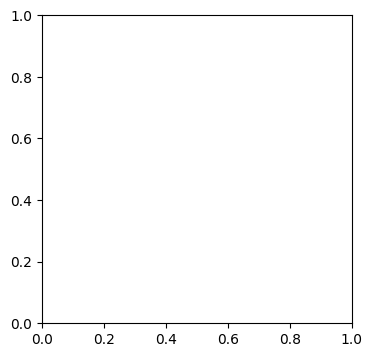

In [38]:
lump = 'TITLE'

viewer.draw_flat(lump)



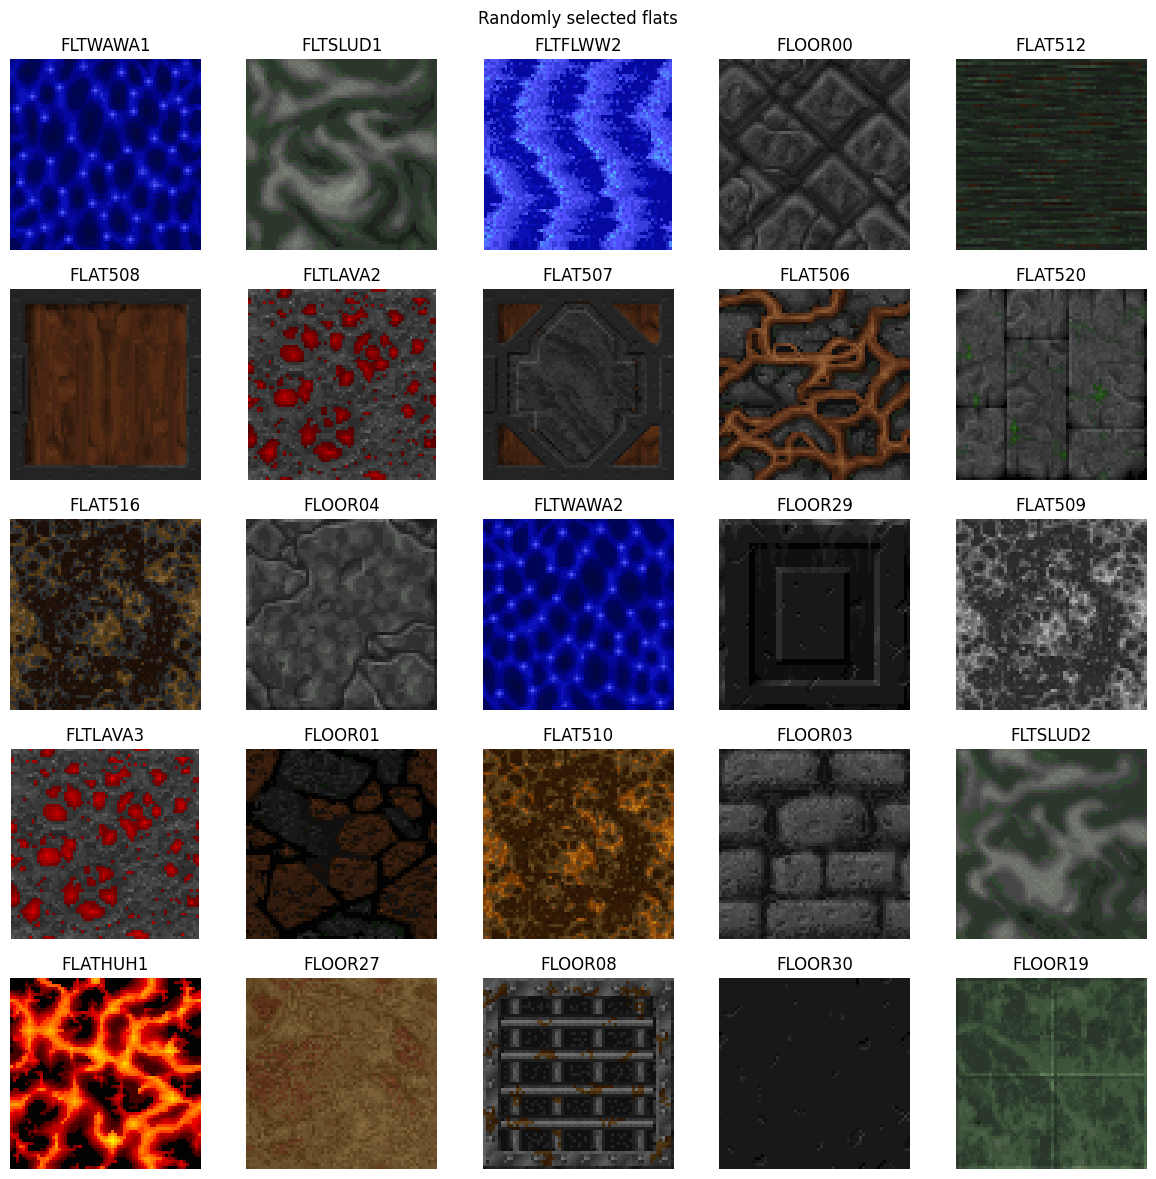

In [24]:
n_flats = 25
fig, ax = plt.subplots(5, 5, figsize=(12, 12))
ax = ax.ravel()

all_flat_names = list(w.flats.keys())
selected_flats = np.random.choice(all_flat_names, size=n_flats, replace=False)

for i, flat_name in enumerate(selected_flats):

    viewer.draw_flat(flat_name, ax=ax[i])
    ax[i].set_title(flat_name)
    ax[i].axis('off')

fig.suptitle('Randomly selected flats')
fig.tight_layout(pad=1.2)

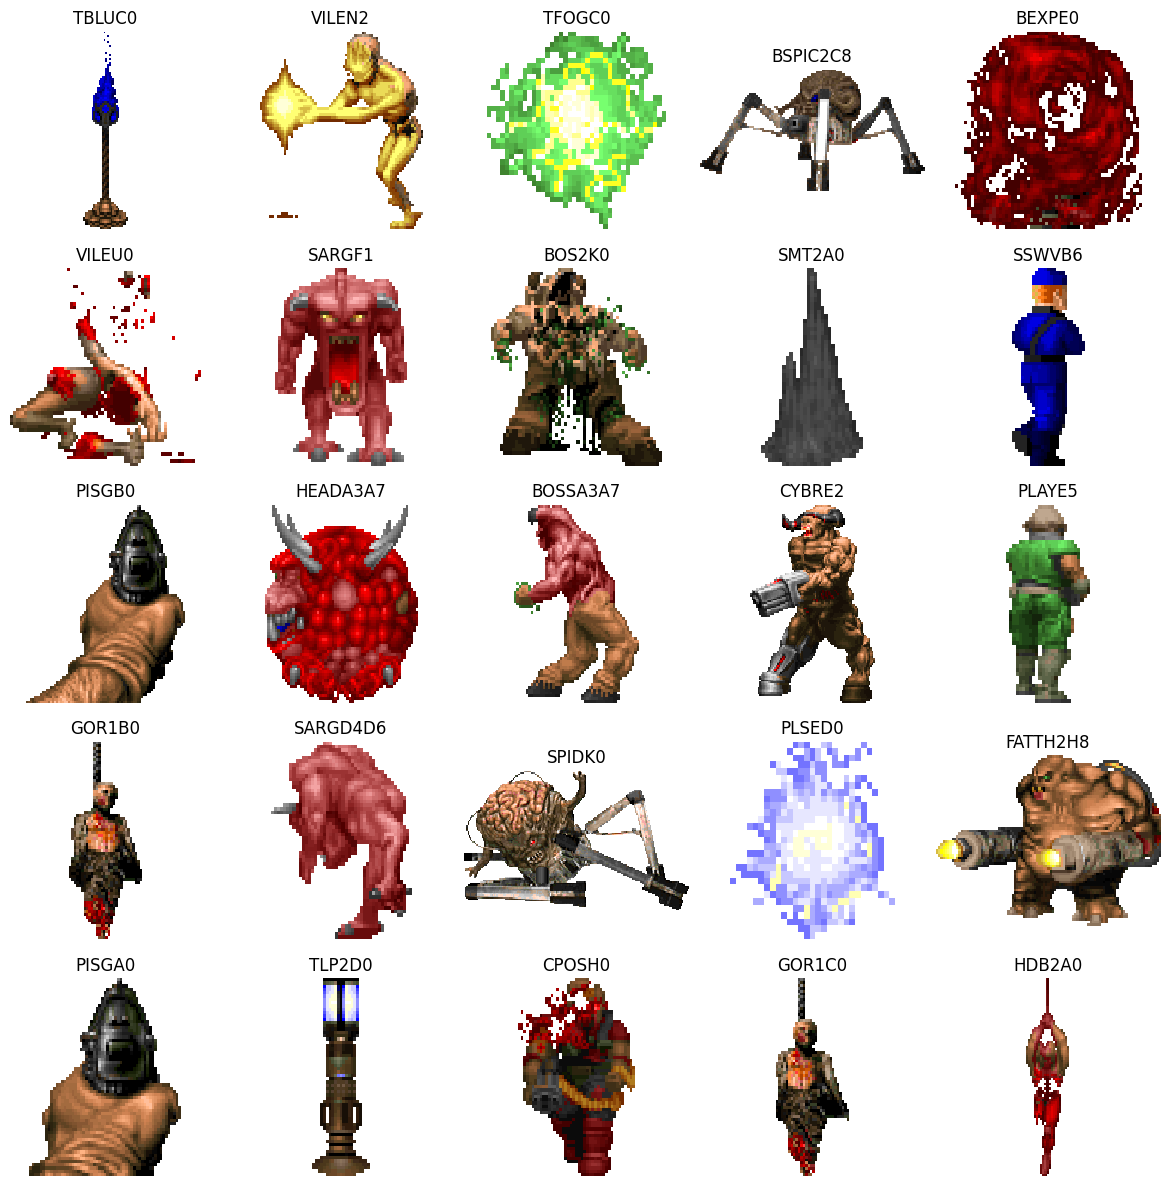

In [6]:
n_sprites = 25
fig, ax = plt.subplots(5, 5, figsize=(12, 12))
ax = ax.ravel()

all_sprite_names = list(w.sprites.keys())
selected_sprites = np.random.choice(all_sprite_names, size=n_sprites, replace=False)

for i, sprite_name in enumerate(selected_sprites):

    rgb_image = w.draw_patch(*w.sprites[sprite_name])

    # Original DOOM had non-square pixels!
    ax[i].imshow(rgb_image / 255, aspect=1.2, interpolation='nearest') 
    ax[i].set_title(sprite_name)
    ax[i].axis('off')

fig.tight_layout(pad=1.2)

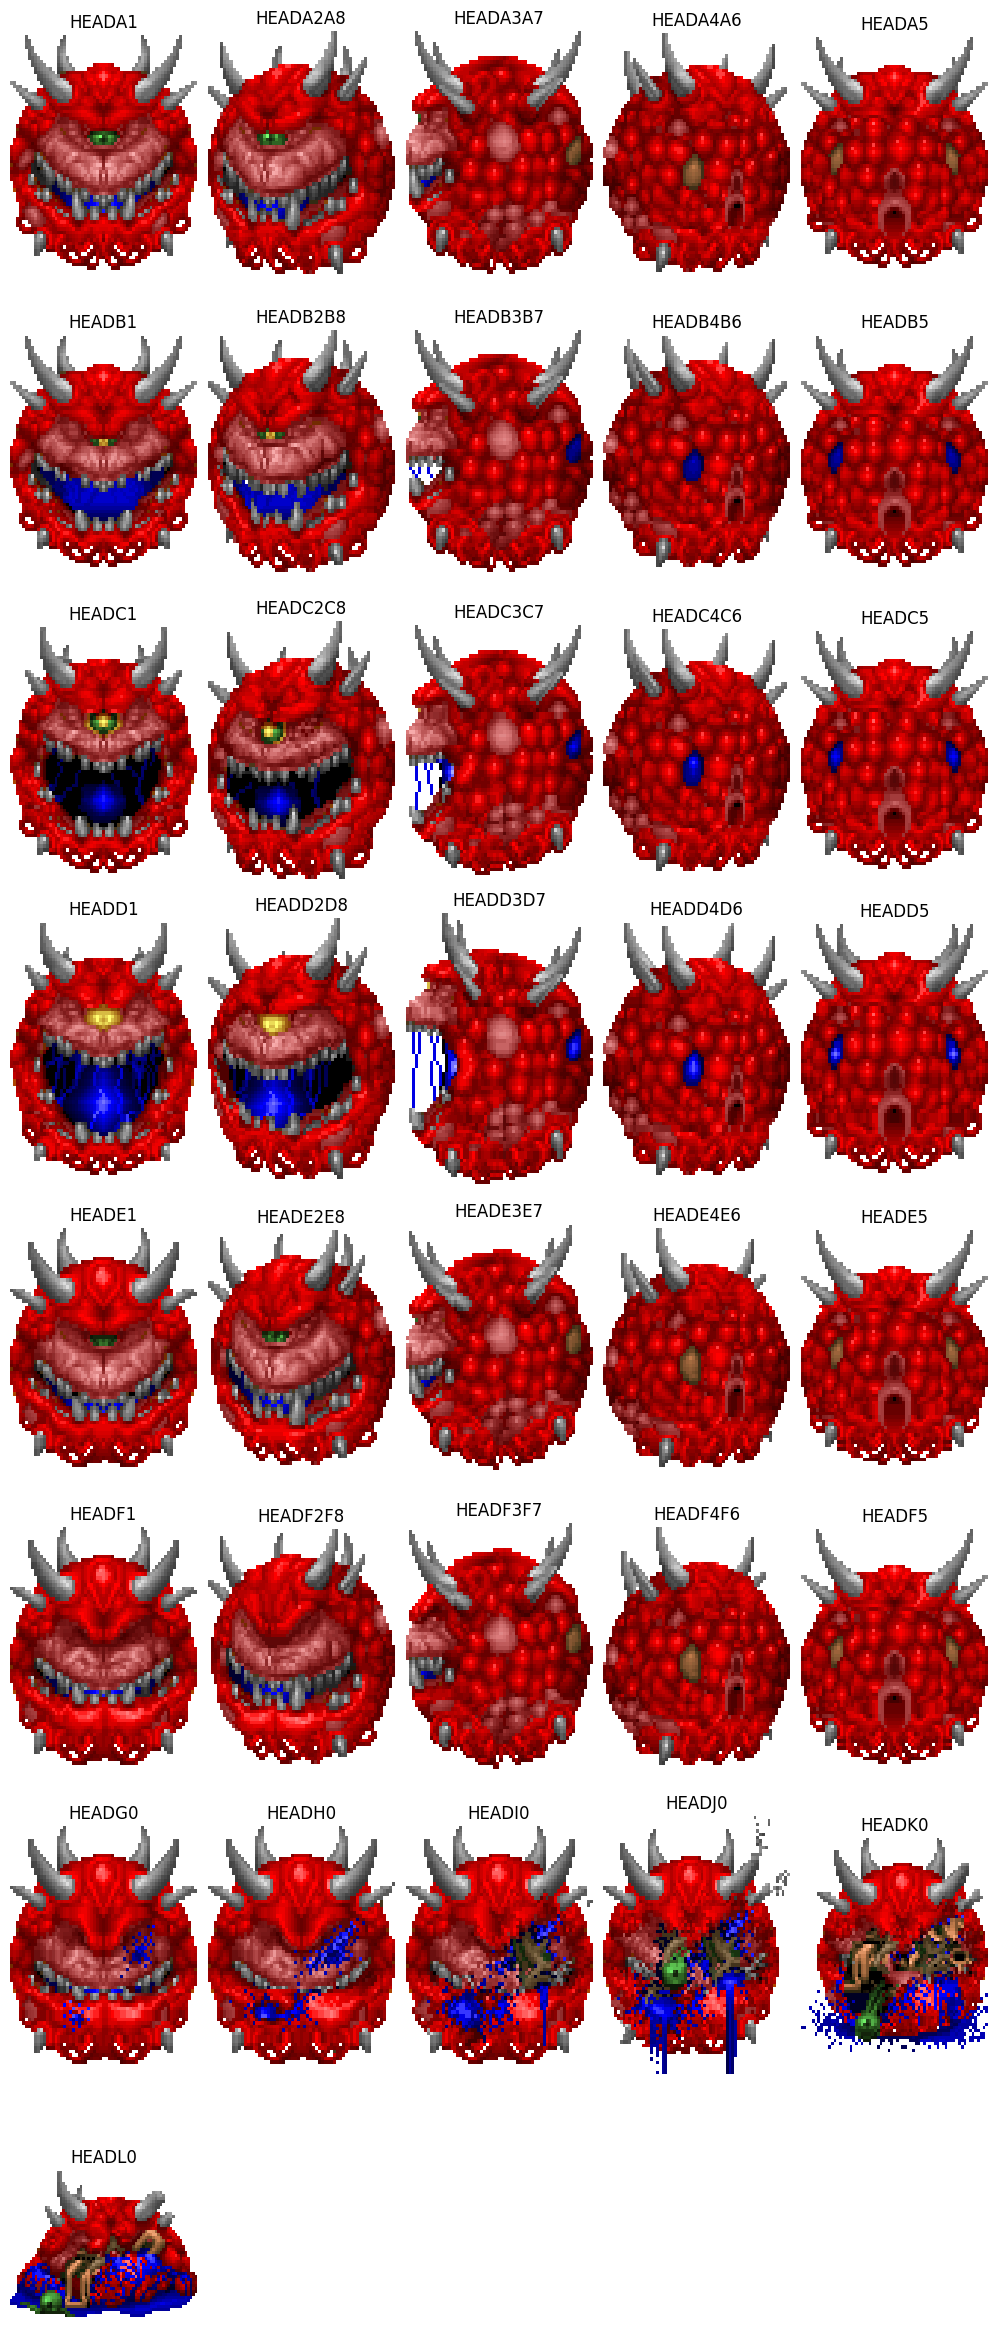

In [7]:
sprite_name = 'HEAD'

sprite_list = w.spritesheets[sprite_name]
ncols=5
nrows = int(np.ceil(len(sprite_list) / ncols))

fig, ax = plt.subplots(ncols=ncols, nrows=nrows, figsize=(10, 3*nrows))
ax = ax.ravel()

for i, (name, offset, size) in enumerate(sprite_list):
    
    rgb_image = w.draw_patch(offset, size)
    ax[i].imshow(rgb_image / 255, aspect=1.2, interpolation='nearest')
    ax[i].set_title(name)
    ax[i].axis('off')

[ax[i].set_visible(False) for i in range(len(sprite_list), len(ax))]
fig.tight_layout(pad=0.8)